In [2]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
import pylab
from bilby.core.prior import Uniform, Sine, Cosine, PowerLaw, Constraint
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.filter.matchedfilter import sigmasq
from pycbc.detector import Detector
from pycbc.psd import analytical
from pycbc.psd import read as psd_read    

%matplotlib inline

In [3]:
def calculate_snr(param_args, ifos_obj, psd_analytical=False, ra=2.2, dec=-1.25, pol=2.1, t_gps=120):
    sample_rate=1024
    apx='IMRPhenomD'
    f_lower=10
    hp, hc=get_td_waveform(approximant=apx,
                            mass1=param_args['mass_1'],
                            mass2=param_args['mass_2'],
                            spin1z=param_args['spin_1z'],
                            spin1x=param_args['spin_1x'],
                            spin1y=param_args['spin_1y'],
                            spin2z=param_args['spin_2z'],
                            spin2x=param_args['spin_2x'],
                            spin2y=param_args['spin_2y'],
                            inclination=param_args['theta_jn'],
                            coa_phase=param_args['phase'],
                            distance=param_args['luminosity_distance'],
                            f_lower=f_lower,
                            delta_t=1.0/sample_rate)


    flow = 10.0
    delta_f = 1.0 / hp.duration 
    flen = int(sample_rate/delta_f)
    if psd_analytical:
        psd = analytical.aLIGOZeroDetHighPower(flen, delta_f, flow) #optimize by calculating only once   
    else:
        read_data = np.genfromtxt('o3_h1.txt')
        psd_data = read_data[:, 1]
        psd_data = psd_data ** 2
        freq = read_data[:, 0]
        psd = psd_read.from_numpy_arrays(freq, psd_data,flen, delta_f, 20)
        psd.data[np.argwhere(psd.data == 0)] = 1
    gw = {'hp': hp, 'hc':hc, 'psd': psd}
    
    for det in ifos_obj:
        fp, fc=det.antenna_pattern(ra, dec, pol, t_gps)
    
        s= fp * gw['hp'] + fc * gw['hc']
        snr = sigmasq(s,psd=gw['psd'], low_frequency_cutoff=10)
        if 'snr_sq' in gw:  
            gw['snr_sq'] += snr
        else:
            gw['snr_sq'] = snr
            
    return np.sqrt(gw['snr_sq'])

In [4]:
#set up ifos objects
ifos=['H1', 'L1', 'V1']
ifos_det = []

for ifo in ifos:
    ifos_det.append(Detector(ifo))

In [6]:
prior=dict(dec=Cosine(name='dec'),
           ra=Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
           theta_jn=Sine(name='theta_jn'))
param_args = dict(mass_1=35,
                  mass_2=35,
                  spin_1z=0,
                  spin_1x=0,
                  spin_1y=0,
                  spin_2z=0,
                  spin_2x=0,
                  spin_2y=0,
                  phase=0,
                  luminosity_distance=1)

In [7]:
#create samples for ra, dec and inclination
n=500
ra_lst=prior['ra'].sample(n)
dec_lst=prior['dec'].sample(n)
theta_jn_lst=prior['theta_jn'].sample(n)

In [ ]:
#optimized minimum distance function
param_args['luminosity_distance']=1
max_distance_opt=list() 
for i in range(n):
    print(i)
    param_args['luminosity_distance']=1
    while True:
        param_args['theta_jn']=theta_jn_lst[i] 
        snr=calculate_snr(param_args, ifos_det, ra=ra_lst[i], dec=dec_lst[i])        
        if snr < 8:
            max_distance_opt.append(param_args['luminosity_distance'])
            break
        if snr >= 16:
            print(f"SNR = {snr}, distance = {param_args['luminosity_distance']}")
            param_args['luminosity_distance']= param_args['luminosity_distance'] * (snr/8)
        else:
            param_args['luminosity_distance']+=10
        print(f"new distance={param_args['luminosity_distance']}")

(array([16., 40., 74., 94., 90., 64., 58., 32., 22., 10.]),
 array([ 228.95431736,  596.85686324,  964.75940911, 1332.66195499,
        1700.56450087, 2068.46704674, 2436.36959262, 2804.2721385 ,
        3172.17468437, 3540.07723025, 3907.97977613]),
 <BarContainer object of 10 artists>)

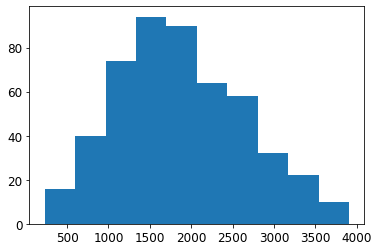

In [104]:
pylab.hist(max_distance_opt)

In [105]:
#calculate the solid angle integral --> not sure about the +pi/2 
d_sa=np.cos(dec_lst)*ra_lst*(dec_lst)
print(np.sum(d_sa)/n)
print(4*np.pi*np.sum(d_sa)/n)

0.14119853723183318
1.774353149060608


In [106]:
print(min(max_distance_opt))

228.95431736079806


In [107]:
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value
from scipy import integrate
from astropy import constants as const

dl = np.arange(1, 10000, 10)
z_lst = list()
for i in dl:
    z_lst.append(z_at_value(Planck15.luminosity_distance, i*u.Mpc).value)
    
cosmo_lst = list()
for z in z_lst:
    e = Planck15.efunc(z)
    cosmo_lst.append(1/(e*(1+z)**3))

kernel = cosmo_lst * (dl**2)
integral = integrate.cumtrapz(kernel, x=z_lst) * u.Mpc ** 2


In [108]:
#i have bins of luminosity distance spaced by 10 --> put every distance into one of those bins, 
#get the integral value there and add
inds = (np.digitize(max_distance_opt,dl))

sum_total = 0 

for i in inds:
    sum_total += integral[i]

h0 = Planck15.H(0)
volume_sens = (1*u.year)*(const.c/h0)*4*np.pi*sum_total/n
print(volume_sens * (u.km / (10**3 * u.m)))

10770913730.56844 Mpc3 yr


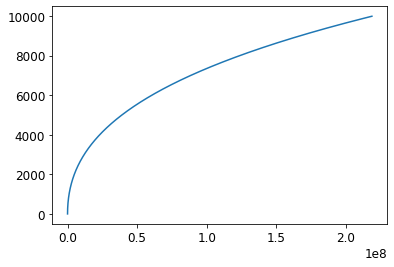

In [53]:
pylab.plot(kernel, dl)